# Новый Python интерфейс BigARTM.

## Пример №1

Здесь приводится простой пример использования нового пользовательского интерфейса на Python библиотеки BigARTM. Мы будем обучать тематическую модель маленькой коллекции 'kos'.
Для начала подключим все необходимые модули (убедитесь, что путь к artm_model.py находится в вашей переменной PATH):

In [1]:
%matplotlib inline
import glob
import matplotlib.pyplot as plt

import artm.artm_model
from artm.artm_model import *

Первым делом содадим тематическую модель. Новый интерфейс позволяет сделать это в одну строчку:

In [2]:
model = ArtmModel(num_topics=15)

ArtmModel — это объект, содержащий в себе всю информацию о текущем состоянии тематической модели. Все наши последующие действия будут производиться в рамках него. Прежде всего распарсим из файлов 'docword' и 'vocab' в формате UCI, если это необходимо:

In [3]:
if len(glob.glob('kos' + "/*.batch")) < 1:
    parse(data_path='', data_format='bow_uci', collection_name='kos')

Следующий шаг — инициализация модели. Сделаем это по словарю, что означает, что
- будет создана матрица Фи с именем 'pwt', число строк и столбцов в ней будет взято исходя из числа слов в словаре и заданного в модели числа тем;
- эа матрица будет заполнена случайными значениями из диапазона (0, 1) и нормализована.

Надо отметить, что этот шаг является опциональным, поскольку модель может быть автоматически инициализирована во время вызовов fit_offline() / fit_online().

In [4]:
model.initialize(dictionary=model.load_dictionary('kos/dictionary'))

ArtmModelпредоставляет возможность использовать все функционалы качества, имеющиеся в BigARTM. Если функционал подключен к модели, то модель будет сохранять все его значения, полученные на момент каждого обновления матрицы Фи.
Для контроля за качеством получаемой модели введём несколько метрик:

In [5]:
model.scores.add(SparsityPhiScore(name='SparsityPhiScore'))
model.scores.add(SparsityThetaScore(name='SparsityThetaScore'))
model.scores.add(PerplexityScore(name='PerplexityScore'))

Также полезно добавить несколько базовых регуляризаторов, повышающих разреженность и различность тем (зададим им стартовые коэффициенты регуляризации, которые можно будет позже изменить)

In [6]:
model.regularizers.add(SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1))
model.regularizers.add(SmoothSparseThetaRegularizer(name='SparseTheta', tau=-2.0))
model.regularizers.add(DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=100000.0))

Теперь попробуем обучить модель в оффлайн-режиме (т.е. обновляя Фи раз за проход по коллекции). Инициируем пять проходов:

In [7]:
model.fit_offline(data_path='kos', num_collection_passes=5)

Проверим результаты первой итерации обучения:

In [8]:
print 'Sparsity Phi:' + str(model.scores_info['SparsityPhiScore'].last_value)
print 'Sparsity Theta:' + str(model.scores_info['SparsityThetaScore'].last_value)

Sparsity Phi:0.425060334009
Sparsity Theta:0.699183673469


Видно, что разреженности матриц пока ещё слишком невелики. Попробуем увеличить по модулю значения коэффициентов регуляризации при разреживающих регуляризаторах:

In [9]:
model.regularizers['SparsePhi'].tau = -0.4
model.regularizers['SparseTheta'].tau = -3.0

Также полезно добавить функционал 'TopTokensScore'. Он позволит нам увидеть самые вероятные слова в каждой полученной теме

In [10]:
model.scores.add(TopTokensScore(name='TopTokensScore', num_tokens=5))

Продолжим обучение модели, инициировав 15 проходов по коллекции:

In [11]:
model.fit_offline(data_path='kos', num_collection_passes=15)

In [12]:
print 'Sparsity Phi:' + str(model.scores_info['SparsityPhiScore'].last_value)
print 'Sparsity Theta:' + str(model.scores_info['SparsityThetaScore'].last_value)

Sparsity Phi:0.638024905879
Sparsity Theta:0.793756073858


Разреженность всё ещё неудовлетворительная. Попробуем ещё усилить разреживание и продолжить обучение:

In [13]:
model.regularizers['SparsePhi'].tau = -1.5
model.regularizers['SparseTheta'].tau = -5.0
model.fit_offline(data_path='kos', num_collection_passes=15)

Нарисуем графики перплексии и разреженностей:

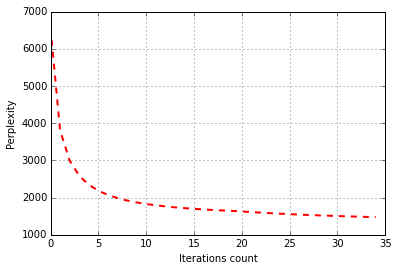

In [14]:
plt.plot(range(model.num_phi_updates), model.scores_info['PerplexityScore'].value, 'r--', linewidth=2)
plt.xlabel('Iterations count')
plt.ylabel('Perplexity')
plt.grid(True)
plt.show()

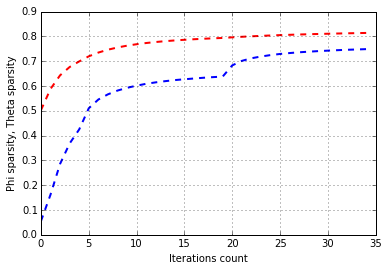

In [15]:
plt.plot(range(model.num_phi_updates), model.scores_info['SparsityPhiScore'].value, 'b--',
         range(model.num_phi_updates), model.scores_info['SparsityThetaScore'].value, 'r--', linewidth=2)
plt.xlabel('Iterations count')
plt.ylabel('Phi sparsity, Theta sparsity')
plt.grid(True)
plt.show()

Для столь маленькой коллекции разреженность достаточная. Напечатаем топовые слова в каждой теме:

In [16]:
for topic_name in model.topic_names:
    print topic_name + ': ',
    print model.scores_info['TopTokensScore'].last_topic_info[topic_name].tokens

@topic_0:  [u'bloggers', u'book', u'convention', u'blogs', u'boat']
@topic_1:  [u'dean', u'clark', u'edwards', u'primary', u'lieberman']
@topic_2:  [u'republican', u'republicans', u'party', u'vote', u'democrats']
@topic_3:  [u'bush', u'administration', u'president', u'cheney', u'house']
@topic_4:  [u'delay', u'house', u'media', u'committee', u'texas']
@topic_5:  [u'democrats', u'states', u'million', u'state', u'democratic']
@topic_6:  [u'iraq', u'war', u'bush', u'iraqi', u'bushs']
@topic_7:  [u'military', u'soldiers', u'abu', u'pentagon', u'iraqi']
@topic_8:  [u'carson', u'coburn', u'oklahoma', u'media', u'speech']
@topic_9:  [u'party', u'nader', u'dean', u'unions', u'ballot']
@topic_10:  [u'kerry', u'bush', u'poll', u'percent', u'voters']
@topic_11:  [u'senate', u'race', u'elections', u'campaign', u'house']
@topic_12:  [u'november', u'account', u'electoral', u'governor', u'house']
@topic_13:  [u'bush', u'administration', u'tax', u'jobs', u'health']
@topic_14:  [u'oil', u'space', u'bla

Последний шаг — сохранение модели. ArtmModel предоставляет две возможности: сохранить модель в формате BigARTM или в .csv файл. 
- в первом случае модель нельзя будет никак визуализировать, но можно загрузить обратно в ArtmModel и продолжить работу с ней;
- .csv файл нельяз загрузить обратно, но на него можно посмотреть глазами.

Воспользуемся обеими возможностями:

In [17]:
model.save(file_name='kos_artm_model')
model.to_csv(file_name='kos_artm_model.csv')

Дополнительно извлечём Тету:

In [18]:
theta_matrix = model.get_theta()

ArtmModel.get_theta() возвращает Теут как объект pandas.DataFrame. Напечатаем её:

In [19]:
print theta_matrix

               1         2     3         4         5         6     7     8     \
@topic_0   0.000000  0.000000     0  0.000000  0.000000  0.000000     0     0   
@topic_1   0.000000  0.000000     0  0.000000  0.000000  0.000000     0     0   
@topic_2   0.000000  0.000000     0  0.000000  0.000000  0.000000     0     0   
@topic_3   0.225274  0.000000     0  0.000000  0.000000  0.000000     0     0   
@topic_4   0.000000  0.000000     0  0.840536  0.161937  0.000000     0     0   
@topic_5   0.170842  0.000000     0  0.000000  0.000000  0.000000     0     0   
@topic_6   0.139775  0.793201     0  0.159464  0.174049  0.000000     0     0   
@topic_7   0.229708  0.000000     0  0.000000  0.000000  0.000000     0     0   
@topic_8   0.000000  0.000000     0  0.000000  0.000000  0.000000     0     0   
@topic_9   0.000000  0.000000     0  0.000000  0.000000  0.000000     0     0   
@topic_10  0.234401  0.206799     0  0.000000  0.664014  0.552273     1     1   
@topic_11  0.000000  0.00000

## Пример №2

Это вторая часть примера использования нового интерфейса библиотеки. Загрузим обратно модель, сохранённую в прошлой части и применим к ней несколько операций.

В первую очередь создадим новую тематическую модель:

In [20]:
new_model = ArtmModel(num_processors=2, num_topics=1, num_document_passes=1)

Вторым шагом добавим в неё функционалы и регуляризаторы. Ограничимся одной новой метрикой и двумя уже знакомыми регуляризаторами:

In [21]:
new_model.scores.add(TopicKernelScore(name='TopicKernelScore'))
new_model.regularizers.add(SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1))
new_model.regularizers.add(DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=100000.0))

Теперь загрузим файл 'kos_artm_model' с моделью обратно в библиотеку

In [22]:
new_model.load('kos_artm_model')

Имейте ввиду, что загружаемая модель перепишет несколько параметров нашего объекта ArtmModel: число и имена тем, матрицу Фи. Также загрузка сотрёт всю информацию о данных метрик, посчитанных ранее. Тем не менее, сами подключенные метрики и регуляризаторы никуда не денуться. В нашем случае это функционал 'TopicKernelScore' и регуляризаторы 'SparsePhi' и 'DecorrealtorPhi'.

Теперь продолжим обучение модели, но, для примера, рассмотрим онлайновый режим. Это означает, что
- число проходов по каждому документу увеличивается
- матрица Фи может быть обновлена произвольное количество раз за один проход по коллекции (но не чаще, чем раз за обработанный батч)
- нам требуется только оин проход по коллекции (но здесь мы сделаем 5, поскольку коллекция 'kos' довольно маленькая).

In [23]:
new_model.num_document_passes = 20
for i in range(5):
    new_model.fit_online(data_path='kos', update_every=4)

Параметр 'update_every' говорит модели о том, раз в сколько батчей следует обновлять матрицу Фи.

Выведем средние харакетристики ядер тем (чистоту и контрастность):

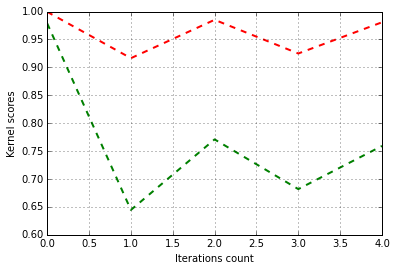

In [24]:
plt.plot(range(new_model.num_phi_updates), new_model.scores_info['TopicKernelScore'].average_contrast, 'g--',
         range(new_model.num_phi_updates), new_model.scores_info['TopicKernelScore'].average_purity, 'r--', linewidth=2)
plt.xlabel('Iterations count')
plt.ylabel('Kernel scores')
plt.grid(True)
plt.show()

Как мы видим, дальнейшее обучение загруженной модели только ухудшило её качество.

Также можно посмотреть на ифнормацию о ядрах каждой темы. Для примера выведем все ядровые слова первой темы:

In [25]:
print new_model.scores_info['TopicKernelScore'].last_topic_info[new_model.topic_names[0]].tokens

[u'allowed', u'award', u'baseball', u'blogads', u'bloggers', u'blogging', u'blogosphere', u'blogs', u'boat', u'book', u'boston', u'bronze', u'curious', u'dailykos', u'drudge', u'drum', u'editors', u'fans', u'franken', u'fun', u'ideological', u'journalism', u'journalists', u'kevin', u'launch', u'limbaugh', u'links', u'lying', u'magazine', u'nevada', u'nyc', u'oreilly', u'owner', u'park', u'petraeus', u'posters', u'propaganda', u'putting', u'reader', u'readers', u'review', u'rewards', u'rnc', u'road', u'rowland', u'rush', u'season', u'selection', u'series', u'sox', u'star', u'starting', u'stations', u'suddenly', u'swift', u'treatment', u'trip', u'universe', u'updates', u'whos', u'writes', u'yankees']


Если у нас есть батч с документами, который не являлся частью обучающей выборки (или являлся, но мы не сохраняли Тету для экономии памяти), и мы хотим узнать столбцы матрицы Теты для него, то следует использовать метод 'find_theta':

In [26]:
test_theta_matrix = model.find_theta(data_path='kos_test', batches=['test_docs.batch'])

ArtmModel.find_theta(), как и ArtmModel.get_theta(), возвращает Тету в виде объекта pandas.DataFrame. Напечатаем ее:

In [27]:
print test_theta_matrix

               3001          3002          3003          3004      3005  \
@topic_0   0.000027  5.470353e-12  8.860754e-05  3.655218e-08  0.023012   
@topic_1   0.000000  7.545636e-08  5.074987e-08  2.936660e-05  0.000895   
@topic_2   0.157189  3.943398e-02  9.634904e-02  3.531444e-02  0.000529   
@topic_3   0.026738  1.165643e-02  1.995699e-04  6.938869e-03  0.000309   
@topic_4   0.042742  6.324405e-01  7.174250e-03  5.326925e-01  0.501939   
@topic_5   0.116401  1.229227e-02  8.142789e-02  2.659805e-01  0.069234   
@topic_6   0.376136  5.741584e-02  1.048846e-01  5.601915e-03  0.097925   
@topic_7   0.163309  1.563597e-01  1.076673e-05  6.481285e-05  0.000017   
@topic_8   0.002779  3.925704e-08  5.331933e-03  2.455392e-03  0.003307   
@topic_9   0.000794  1.424964e-03  8.680467e-03  1.836287e-02  0.000393   
@topic_10  0.031543  4.863139e-04  6.822457e-01  9.276280e-02  0.158388   
@topic_11  0.010005  2.929365e-02  4.954084e-04  1.317805e-02  0.106768   
@topic_12  0.000001  1.54